# All 19 Sites!

/tmp/ipykernel_2210934/702546931.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


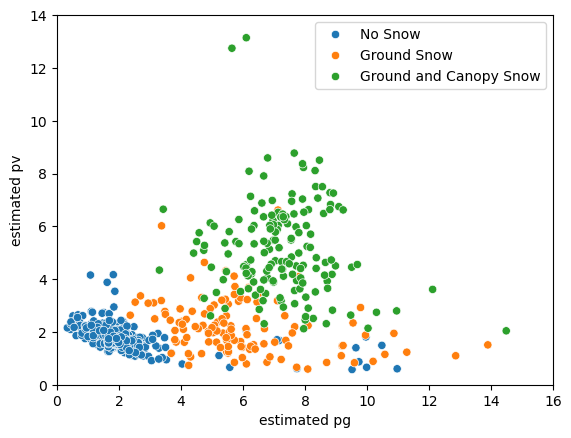

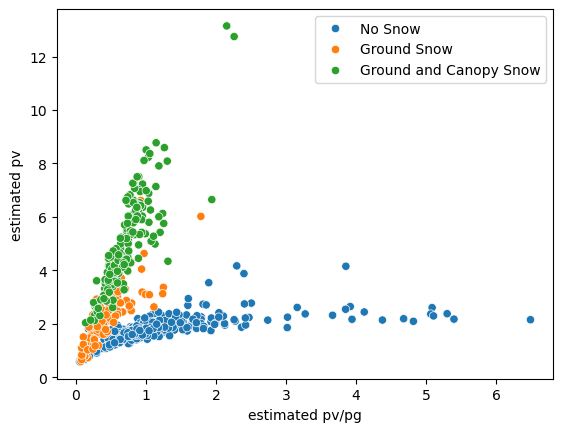

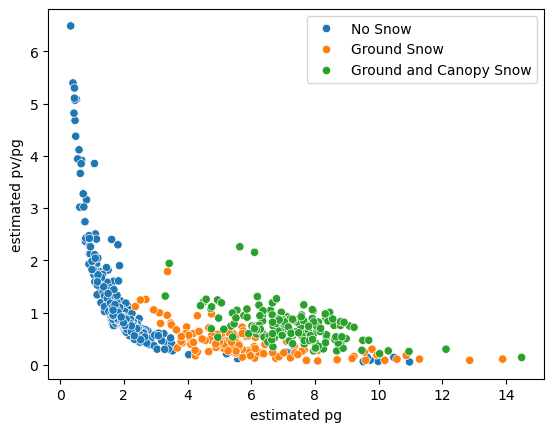

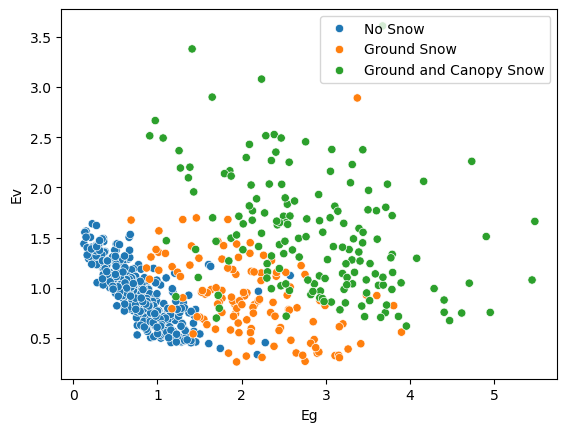

678


,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
889,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.279784,0.453795,22.500000,1.923399,0.02,0.0,0.0,4.0,2.000000,1.546578,1.546578,0.0,No Snow
891,old_jack_pine,07/05/2019,53.947832,-104.730241,0.078967,0.611125,7.738981,1.745712,0.396391,24.086957,1.590534,0.02,0.0,0.0,4.0,2.000000,1.438265,1.438265,0.0,No Snow
899,old_jack_pine,09/10/2023,53.911795,-104.684352,0.055025,0.603731,10.971891,1.278363,0.470724,29.561404,99.058438,0.00,0.0,1.0,23.0,0.000000,1.889532,1.889532,0.0,No Snow
908,old_jack_pine,09/10/2023,53.938823,-104.684352,0.211688,1.106129,5.225269,0.606980,0.769211,27.581818,112.397816,0.00,0.0,1.0,23.0,0.000000,1.548690,1.548690,0.0,No Snow
922,old_jack_pine,10/07/2023,53.920805,-104.714944,0.089185,0.868483,9.737958,1.250415,0.715749,24.361702,2.633845,0.00,0.0,0.0,21.0,0.000000,1.533607,1.533607,0.0,No Snow
1040,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060520,0.575955,9.516730,2.185239,0.334829,27.641509,100.915144,0.00,0.0,1.0,20.0,0.000000,2.402427,2.402427,0.0,No Snow
1767,underc,08/11/2020,46.256423,-89.491715,0.145153,1.399496,9.641527,2.198478,0.965092,19.228571,5.538420,0.00,0.0,0.0,8.0,0.000000,1.579870,1.579870,0.0,No Snow
2040,willowcreek,05/09/2020,45.801495,-90.046791,0.142284,1.490951,10.478689,1.204456,1.145723,27.264151,3.938785,0.00,0.0,0.0,7.0,0.000000,1.640595,1.640595,0.0,No Snow
2042,willowcreek,05/09/2020,45.819514,-90.046791,0.181738,1.811201,9.966001,0.775022,1.230793,33.000000,3.568269,0.00,0.0,0.0,7.0,0.000000,1.912085,1.912085,0.0,No Snow
2055,willowcreek,06/03/2024,45.801495,-90.111409,0.118299,0.659337,5.573489,1.227348,0.537955,26.545455,155.074660,0.00,0.0,1.0,18.0,0.000000,1.502322,1.502322,0.0,No Snow


In [17]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg': 'mean',
    'Ev': 'mean',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
# plt.plot([0.3,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg', y='Ev', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data[(data['pg']>4.5)&(data['JointSnow']==0)]#.sort_values('snr')

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg','Ev','Eg']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified

/tmp/ipykernel_2210934/4104301870.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
[[391   7]
 [ 13 267]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       398
           1       0.97      0.95      0.96       280

    accuracy                           0.97       678
   macro avg       0.97      0.97      0.97       678
weighted avg       0.97      0.97      0.97       678



,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
241,delta_junction,30/04/2022,63.876595,-145.782096,0.449075,1.705848,3.798580,1.471171,0.711371,30.508197,...,0.065574,19.0,0.000000,1.973366,1.973366,1.0,Ground Snow,1,1,0
243,delta_junction,30/04/2022,63.885605,-145.782096,0.540224,2.055209,3.804364,1.171374,0.791195,26.224490,...,0.632653,19.0,0.000000,1.991006,1.991006,1.0,Ground Snow,1,1,0
325,glees,28/05/2023,41.386923,-106.209391,1.115044,2.633419,2.361718,0.870031,1.197005,25.745098,...,0.000000,19.0,0.627451,1.841683,1.841683,1.0,Ground Snow,1,1,0
421,hyytiala,13/03/2022,61.834176,24.266319,0.331440,1.621794,4.893174,0.905947,1.085529,24.909091,...,0.000000,15.0,0.000000,1.431260,1.431260,1.0,Ground Snow,1,1,0
433,hyytiala,13/03/2022,61.870213,24.285413,1.240825,3.127500,2.520500,1.301128,0.900204,23.044444,...,0.000000,15.0,0.000000,1.809580,1.809580,1.0,Ground Snow,1,1,0
654,lacclair,03/04/2024,46.938586,-71.676199,0.515285,2.100746,4.076860,1.015542,1.174903,21.190476,...,0.738095,22.0,0.000000,1.866963,1.866963,1.0,Ground Snow,1,1,0
656,lacclair,03/04/2024,46.956605,-71.715793,0.791869,2.495542,3.151457,0.922808,1.306686,22.714286,...,1.000000,22.0,0.000000,1.906885,1.906885,1.0,Ground Snow,1,1,0
889,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.279784,0.453795,22.500000,...,0.000000,4.0,2.000000,1.546578,1.546578,0.0,No Snow,0,0,1
1040,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060520,0.575955,9.516730,2.185239,0.334829,27.641509,...,1.000000,20.0,0.000000,2.402427,2.402427,0.0,No Snow,0,0,1
1767,underc,08/11/2020,46.256423,-89.491715,0.145153,1.399496,9.641527,2.198478,0.965092,19.228571,...,0.000000,8.0,0.000000,1.579870,1.579870,0.0,No Snow,0,0,1


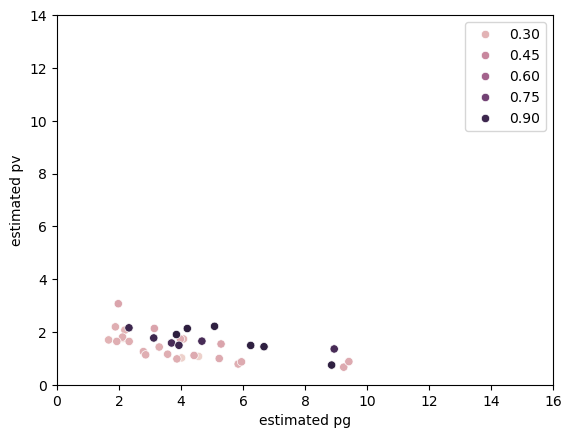

37


,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow
93,delta_junction,02/05/2021,63.867586,-145.761632,0.234979,1.072854,4.565743,1.680912,0.476190,24.021277,0.731000,0.20,0.0,0.000000,16.0,0.000000,1.883530,1.883530,0.20
99,delta_junction,02/05/2021,63.894614,-145.782096,0.252831,1.016108,4.018927,1.840747,0.369396,20.450000,0.593018,0.20,0.0,0.075000,16.0,0.000000,1.702500,1.702500,0.20
193,delta_junction,26/04/2024,63.876595,-145.761632,0.824436,1.753913,2.127408,1.447368,0.625000,27.914286,0.299608,0.20,0.0,0.000000,32.0,0.000000,1.414791,1.414791,0.20
703,lacclair,09/04/2021,46.983632,-71.676199,0.944992,2.068254,2.188648,0.367857,1.416071,21.142857,0.455364,0.30,0.0,0.000000,12.0,2.000000,1.533761,1.533761,0.30
698,lacclair,09/04/2021,46.956605,-71.676199,1.019659,1.696912,1.664196,0.416667,1.133929,24.375000,0.432115,0.30,0.0,0.000000,12.0,2.000000,1.363735,1.363735,0.30
701,lacclair,09/04/2021,46.974623,-71.676199,0.424979,1.733683,4.079452,0.656250,1.258065,23.800000,0.442186,0.30,0.0,0.000000,12.0,1.857143,1.324692,1.324692,0.30
1227,oregon_yp,25/01/2019,44.346323,-121.624889,0.253024,0.978495,3.867199,1.435185,0.566667,21.578947,131.457102,0.32,0.0,1.000000,0.0,0.000000,1.408977,1.408977,0.32
1228,oregon_yp,25/01/2019,44.346323,-121.587111,0.433418,1.428489,3.295866,1.178571,0.540659,21.250000,100.945246,0.32,0.0,1.000000,0.0,0.000000,1.948468,1.948468,0.32
1214,oregon_yp,25/01/2019,44.292268,-121.637482,0.324032,1.156142,3.567988,1.230159,0.667142,22.500000,108.872076,0.32,0.0,0.805556,0.0,0.000000,1.545276,1.545276,0.32
1220,oregon_yp,25/01/2019,44.310286,-121.587111,1.164254,2.192269,1.882982,1.129032,0.676471,27.400000,103.971202,0.32,0.0,1.000000,0.0,0.000000,1.769804,1.769804,0.32


In [16]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg': 'median',
    'Ev': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] > 0.05)&(df_grouped['FSC'] < 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

plt.figure()
sns.scatterplot(data = data.sort_values('FSC'), x='pg', y='pv', hue='FSC')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data.sort_values('FSC')